In [1]:
import json
import random
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import Counter, defaultdict
plt.rcParams["figure.figsize"] = (20, 5)

## Functions

In [2]:
def get_plot_data(dir_path):
    num_dirs = len(os.listdir(dir_path))
    dirs = [dir_path / f'sim_{i}' for i in range(num_dirs)]
    markets, agents, rl_states, lengths, timesteps = [], [], [], [], []
    for _dir in dirs:
        security_path = _dir / "TSMC.json"
        agent_path = _dir / "agent.json"
        rl_path = _dir / 'rl_agent.json'
        config_path = _dir / 'config.json'
        market = json.loads(security_path.read_text())
        markets.append(market)
        agents.append(json.loads(agent_path.read_text()))
        rl_states.append(json.loads(rl_path.read_text()))
        lengths.append(len(market['price']))
        timesteps.append([i for i in range(len(market['price']))])
    print(f"Simulation times: {len(dirs)}")
    print(f"Average training length: {sum(lengths) / len(lengths)}")
    return markets, agents, rl_states, lengths, timesteps

def plot_market(markets):
    avg_prices, avg_values = [], []
    avg_bids, avg_asks = [], []

    for i, market in enumerate(markets):
        plt.plot(market['price'], label = f"sim_{i}")
        
        
    plt.legend()
    plt.title("Prices by time")
    plt.show()

    for i, market in enumerate(markets):
        plt.plot(market['price'], label = "price")    
        plt.plot(market['value'], label = "value")
        plt.legend()
        plt.show()
        avg_prices.append(sum(market['price']) / len(market['price']))
        avg_values.append(sum(market['value']) / len(market['value']))
        avg_bids.append(sum(market['bid']) / len(market['bid']))
        avg_asks.append(sum(market['ask']) / len(market['ask']))

        
    plt.plot(avg_prices, label = 'Price')
    plt.plot(avg_values, label = 'Value')
    plt.legend()
    plt.title("Average price and value by time")
    plt.show()

    plt.plot(avg_bids, label = 'Bid')
    plt.plot(avg_asks, label = 'Ask')
    plt.legend()
    plt.title("Average bid and ask by time")
    plt.show()
    print(f"Average step per bid quantity per agent: {1 / (sum([sum(market['bid']) / len(market['bid']) for market in markets]) / len(markets) / agent_number)}")
    print(f"Average step per ask quantity per agent: {1 / (sum([sum(market['ask']) / len(market['ask']) for market in markets]) / len(markets) / agent_number)}")
    
def plot_total_distribution_of_return(rl_states):
    all_agent_returns = []
    for rl_state in rl_states:
        for agent_state in rl_state.values():
            returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
            all_agent_returns.append(round(returns * 100))
    num_pos_returns = len([ret for ret in all_agent_returns if ret > 0])
    num_neg_returns = len([ret for ret in all_agent_returns if ret < 0])
    agent_returns_counter = Counter(all_agent_returns)
    returns_x = sorted(agent_returns_counter.keys())
    returns_y = [agent_returns_counter[x] for x in returns_x]
    plt.scatter(returns_x, returns_y)
    print(f"Rate of positive returns: {num_pos_returns / (num_pos_returns + num_neg_returns)}")
    print(f"Rate of negtive returns: {num_neg_returns / (num_pos_returns + num_neg_returns)}")
    
def plot_distribution_of_return_by_agent(rl_states):
    agent_ids = rl_states[0].keys()
    agent_returns = {agent_id: [] for agent_id in agent_ids}

    for rl_state in rl_states:
        for agent_id, agent_state in rl_state.items():
            returns = (agent_state['states'][-1]['agent_state']['wealth'] - agent_state['states'][0]['agent_state']['wealth']) / agent_state['states'][0]['agent_state']['wealth']
            agent_returns[agent_id].append(round(returns * 100, 2))
    avg_agent_returns = [round(sum(agent_return) / len(agent_return)) for agent_return in agent_returns.values()]
    agent_returns_counter = Counter(avg_agent_returns)
    returns_x = sorted(agent_returns_counter.keys())
    returns_y = [agent_returns_counter[x] for x in returns_x]
    plt.scatter(returns_x, returns_y)
    plt.title('Returns by agent')
    
    
    plt.figure(figsize=(40, 10))
    returns_progress = [returns[-1] - returns[0] for returns in agent_returns.values()]
    plt.scatter(list(range(len(returns_progress))), returns_progress)
    num_pos_progress = len([progress for progress in returns_progress if progress > 0])
    num_neg_progress = len([progress for progress in returns_progress if progress < 0])
    print(f"Positive progress: {num_pos_progress / len(returns_progress)}")
    print(f"Negative progress: {num_neg_progress / len(returns_progress)}")
#     return agent_returns

    
def plot_average_loss_by_time(rl_states, markets, agent_ids):
    # Agent average loss
    total_policy_loss = {}
    total_value_loss = {}
    length = len(markets[0]['price'][250:])
    for agent_id in agent_ids:
        agent_policy_losses = []
        agent_value_losses = []
        for states in rl_states:
            agent_policy_loss = sum(states[agent_id]['policy_loss'])
            agent_value_loss = sum(states[agent_id]['value_loss'])
            agent_policy_losses.append(agent_policy_loss)
            agent_value_losses.append(agent_value_loss)
        total_policy_loss[agent_id] = agent_policy_losses
        total_value_loss[agent_id] = agent_value_losses

    avg_policy_loss = [sum([total_policy_loss[agent_id][i] for agent_id in agent_ids]) / len(agent_ids) for i in range(len(rl_states))]
    avg_value_loss = [sum([total_value_loss[agent_id][i] for agent_id in agent_ids]) / len(agent_ids) for i in range(len(rl_states))]
    plt.plot(avg_policy_loss)
    plt.show()
    plt.plot(avg_value_loss)

def plot_reward_by_time(rl_states, agent_id):
    for _, states in enumerate(rl_states):
        total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []

        for reward in states[agent_id]['rewards']:
            total_reward.append(reward['weighted_reward'])
            wealth_reward.append(reward['wealth_reward'])
            strategy_reward.append(reward['strategy_reward'])

        for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
            plt.plot(value, label = label)
        plt.legend()
        plt.show()

        wealth_weight = {'short': 0.35, 'mid': 0.25, 'long': 0.25, 'base': 0.15}
        short_steps = 20
        mid_steps = 60
        long_steps = 250
        risk_free_rate = 0.0004
        rewards = []
        short_changes, mid_changes, long_changes, base_changes = [], [], [], []
        risk_free_return = [risk_free_rate]
        for i, state in enumerate(states[agent_id]['states']):
            total_steps = i+1
            present_wealth = state['agent_state']['wealth']
            base_wealth = states[agent_id]['states'][0]['agent_state']['wealth']
            short_wealths = [present_wealth] + [s['agent_state']['wealth'] for s in states[agent_id]['states'][:i][-short_steps:]]
            short_wealth = sum(short_wealths) / len(short_wealths)
            mid_wealths = [present_wealth] + [s['agent_state']['wealth'] for s in states[agent_id]['states'][:i][-mid_steps:]]
            mid_wealth = sum(mid_wealths) / len(mid_wealths)
            long_wealths = [present_wealth] + [s['agent_state']['wealth'] for s in states[agent_id]['states'][:i][-long_steps:]]
            long_wealth = sum(long_wealths) / len(long_wealths)

            short_change = (present_wealth - short_wealth) / short_wealth - pow(risk_free_rate, short_steps)
            mid_change = (present_wealth - mid_wealth) / mid_wealth - pow(risk_free_rate, mid_steps)
            long_change = (present_wealth - long_wealth) / long_wealth - pow(risk_free_rate, long_steps)
            base_change = (present_wealth - base_wealth) / base_wealth - pow(risk_free_rate, i)
            risk_free_return.append((1 + risk_free_return[-1]) * (1 + risk_free_rate) - 1)
            short_changes.append(short_change)
            mid_changes.append(mid_change)
            long_changes.append(long_change)
            base_changes.append(base_change)

            wealth_reward = 10 * (wealth_weight['short']*short_change + wealth_weight['mid']*mid_change + wealth_weight['long']*long_change + wealth_weight['base']*base_change)
            rewards.append(wealth_reward)

        plt.plot(short_changes, label='short', color = 'r')
        plt.plot(mid_changes, label='mid', color = 'g')
        plt.plot(long_changes, label='long', color = 'b')
        plt.plot(base_changes, label='base', color = 'k')
        plt.plot(risk_free_return, label='risk_free_return', color = 'y')
        plt.axhline(y = pow(1+risk_free_rate, short_steps)-1, linestyle='-', color = 'r')
        plt.axhline(y = pow(1+risk_free_rate, mid_steps)-1, linestyle='-', color = 'g')
        plt.axhline(y = pow(1+risk_free_rate, long_steps)-1, linestyle='-', color = 'b')
        plt.legend()
        plt.show()

def sample_agent_id(group_name, agent_number):
    return f"{group_name}_{random.randint(0, agent_number - 1)}"

def plot_wealth_by_time(rl_states, agent_id):    
    for i, rl_state in enumerate(rl_states):
        agent_state = rl_state[agent_id]['states']
        cash = [state['agent_state']['cash'] for state in agent_state]
        holding = [state['agent_state']['TSMC'] for state in agent_state]
        wealth = [state['agent_state']['wealth'] for state in agent_state]
        plt.plot(wealth, label = f"sim_{i}")
        plt.title('Wealth')
        plt.legend()
        
def plot_holdings(rl_states, agent_id):
    # Holdings
    agent_state = rl_states[-1][agent_id]['states']
    cash = [state['agent_state']['cash'] for state in agent_state]
    holding = [state['agent_state']['TSMC'] for state in agent_state]
    wealth = [state['agent_state']['wealth'] for state in agent_state]
    plt.plot(cash, label = "Cash")
    plt.plot(wealth, label = "Wealth")
    plt.legend()
    plt.show()
    plt.plot(holding, label = "TSMC")
    plt.legend()

def plot_loss(rl_states, agent_id):
    policy_loss = []
    value_loss = []
    for i, states in enumerate(rl_states):

        policy_loss += states[agent_id]['policy_loss']
        value_loss += states[agent_id]['value_loss']

    plt.plot(policy_loss, label = f"Policy loss")
    plt.legend()
    plt.show()

    plt.plot(value_loss, label = f"Value loss")
    plt.legend()
    plt.show()
def plot_action(rl_states, markets, agent_id):
    # sample agent to analyse
    action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
    tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
    print(agent_id)
    for state, market in zip(rl_states, markets):
        orders = []
        counter = {"BID": 0, "ASK": 0, "HOLD": 0}
        for i, action in enumerate(state[agent_id]['actions']):
            bid_or_ask = action_ref[action[0]]
            ticks = 1
            price = market['price'][249+i] + tick_size * ticks
            volume = 1
            order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
            counter[bid_or_ask] += 1
            orders.append(order)

        total_actions = sum(counter.values())
        print(counter)
        print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
        bid_x, bid_y = [], []
        ask_x, ask_y = [], []
        bid_sizes, ask_sizes = [], []
        bid_colors, ask_colors = [], []
        base_size = 10
        for i, order in enumerate(orders):
            if order['bid_or_ask'] == 'BID':
        #         if order['time'] > 5000 and order['time'] < 5100:
                bid_x.append(order['time'])
                bid_y.append(order['price'])
                bid_colors.append('r')
                bid_sizes.append(base_size * order['volume'])
            if order['bid_or_ask'] == 'ASK':
        #         if order['time'] > 5000 and order['time'] < 5100:
                ask_x.append(order['time'])
                ask_y.append(order['price'])
                ask_colors.append('g')  
                ask_sizes.append(base_size * order['volume'])
        plot_price = market['price'][250:]
        plot_value = market['value'][250:]
        x = np.arange(len(plot_price))
        plt.figure(figsize=(80, 20))
        plt.plot(x, plot_price, label = "price")
        plt.plot(x, plot_value, label = "value")
        plt.legend()
        plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
        plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
        plt.show()
def plot_action_with_reward(rl_states, markets, agent_id):
    # sample agent to analyse
    action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
    tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
    print(agent_id)
    for state, market in zip(rl_states, markets):
        orders = []
        counter = {"BID": 0, "ASK": 0, "HOLD": 0}
        for i, action in enumerate(state[agent_id]['actions']):
            bid_or_ask = action_ref[action[0]]
            ticks = 1
            price = market['price'][249+i] + tick_size * ticks
            volume = 1
            order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
            counter[bid_or_ask] += 1
            orders.append(order)

        total_actions = sum(counter.values())
        print(counter)
        print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
        bid_x, bid_y = [], []
        ask_x, ask_y = [], []
        bid_sizes, ask_sizes = [], []
        bid_colors, ask_colors = [], []
        base_size = 10
        for i, order in enumerate(orders):
            if order['bid_or_ask'] == 'BID':
        #         if order['time'] > 5000 and order['time'] < 5100:
                bid_x.append(order['time'])
                bid_y.append(order['price'])
                bid_colors.append('r')
                bid_sizes.append(base_size * order['volume'])
            if order['bid_or_ask'] == 'ASK':
        #         if order['time'] > 5000 and order['time'] < 5100:
                ask_x.append(order['time'])
                ask_y.append(order['price'])
                ask_colors.append('g')  
                ask_sizes.append(base_size * order['volume'])
        plot_price = market['price'][250:]
        plot_value = market['value'][250:]
        x = np.arange(len(plot_price))
        plt.figure(figsize=(80, 20))
        plt.plot(x, plot_price, label = "price")
        plt.plot(x, plot_value, label = "value")
        plt.legend()
        plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
        plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
        plt.show()

        total_reward, wealth_reward, action_reward, strategy_reward = [], [], [], []

        for reward in state[agent_id]['rewards']:
            total_reward.append(reward['weighted_reward'])
            wealth_reward.append(reward['wealth_reward'])
            strategy_reward.append(reward['strategy_reward'])

        for label, value in zip(['Total', 'Wealth', 'Action', 'Strategy'], [total_reward, wealth_reward, action_reward, strategy_reward]):
            plt.plot(value, label = label)
        plt.legend()
        plt.show()
    #     weighted_reward = [reward['weighted_reward'] for reward in rl_state[agent_id]['rewards']]
    #     wealth_reward = [reward['wealth_reward'] for reward in rl_state[agent_id]['rewards']]
    #     strategy_reward = [reward['straty'] for reward in rl_state[agent_id]['rewards']]
    #     plt.plot(weighted_reward, label = "Total reward")
    #     plt.plot(wealth_reward, label = "Wealth reward")
    #     plt.plot(strategy_reward, label = "Strategy reward")
    #     plt.legend()
    #     plt.show()

def plot_action(rl_states, markets, agent_id):
    # sample agent to analyse
    action_ref = {0: "BID", 1: "ASK", 2: "HOLD"}
    tick_ref = {i: tick for i, tick in zip(list(range(0, 9)), list(range(-4, 5)))}
    print(agent_id)
    for state, market in zip(rl_states, markets):
        orders = []
        counter = {"BID": 0, "ASK": 0, "HOLD": 0}
        for i, action in enumerate(state[agent_id]['actions']):
            bid_or_ask = action_ref[action[0]]
            ticks = 1
            price = market['price'][249+i] + tick_size * ticks
            volume = 1
            order = {'time': i, "bid_or_ask": bid_or_ask, "price": price, "volume": volume}
            counter[bid_or_ask] += 1
            orders.append(order)

        total_actions = sum(counter.values())
        print(counter)
        print(f"Bid: {counter['BID'] / total_actions}\nAsk: {counter['ASK'] / total_actions}\nHold: {counter['HOLD'] / total_actions}")
        bid_x, bid_y = [], []
        ask_x, ask_y = [], []
        bid_sizes, ask_sizes = [], []
        bid_colors, ask_colors = [], []
        base_size = 10
        for i, order in enumerate(orders):
            if order['bid_or_ask'] == 'BID':
        #         if order['time'] > 5000 and order['time'] < 5100:
                bid_x.append(order['time'])
                bid_y.append(order['price'])
                bid_colors.append('r')
                bid_sizes.append(base_size * order['volume'])
            if order['bid_or_ask'] == 'ASK':
        #         if order['time'] > 5000 and order['time'] < 5100:
                ask_x.append(order['time'])
                ask_y.append(order['price'])
                ask_colors.append('g')  
                ask_sizes.append(base_size * order['volume'])
        plot_price = market['price'][250:]
        plot_value = market['value'][250:]
        x = np.arange(len(plot_price))
        plt.figure(figsize=(80, 20))
        plt.plot(x, plot_price, label = "price")
        plt.plot(x, plot_value, label = "value")
        plt.legend()
        plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
        plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
        plt.show()

        
        
def cal_good_action(rl_states, agent_id):
    for rl_state in rl_states:
        gaps = [state['observations'][0] for state in rl_state[agent_id]['states']]
        prices = [state['observations'][1] for state in rl_state[agent_id]['states']]
        wealths = [state['observations'][2] for state in rl_state[agent_id]['states']]
        actions = [action[0] for action in rl_state[agent_id]['actions']]

        expections = {'Good': 0, 'Bad': 0, 'Hold': 0}
        for gap, action in zip(gaps, actions):
            if gap >= 0:
                if action == 1:
                    expections['Good'] += 1
                elif action == 0:
                    expections['Bad'] += 1
                else:
                    expections['Hold'] += 1
            if gap < 0:
                if action == 0:
                    expections['Good'] += 1
                elif action == 1:
                    expections['Bad'] += 1
                else:
                    expections['Hold'] += 1
        print(f"Good: {expections['Good'] / len(gaps)}, Bad: {expections['Bad'] / len(gaps)}, Hold: {expections['Hold'] / len(gaps)}")
        
def get_max_return_agent_id(rl_states, _type = None):
    max_return, max_agent_id = 0, 0
    for agent_id, returns in agent_returns.items():
#         if not agent_id.startswith('ppo_tr'):
#             continue
        if sum(returns) >= max_return:
            max_agent_id = agent_id
            max_return = sum(returns)
    return max_agent_id, max_return

## Train

In [103]:
tr_agent_number = 250
va_agent_number = 250
sc_agent_number = 500
tr_group_name = f"ppo_tr_{sc_agent_number}"
va_group_name = f"ppo_va_{sc_agent_number}"
sc_group_name = f"ppo_sc_{sc_agent_number}"
agent_number = 500
tick_size = 0.1
config_name = "scaling_500_no_rule_randomwealthweight_wealthobs_noevent_high_ticks"
record_path = Path(f"simulation_result/multi/{config_name}")
config_path = record_path / 'config.json'
config = (json.loads(config_path.read_text()))

In [104]:
train_dir_path = record_path / 'train'
train_markets, train_agents, train_rl_states, train_lengths, train_timesteps = get_plot_data(train_dir_path)
agent_ids = list(train_rl_states[0].keys())

Simulation times: 4
Average training length: 1250.0


### Price & Value

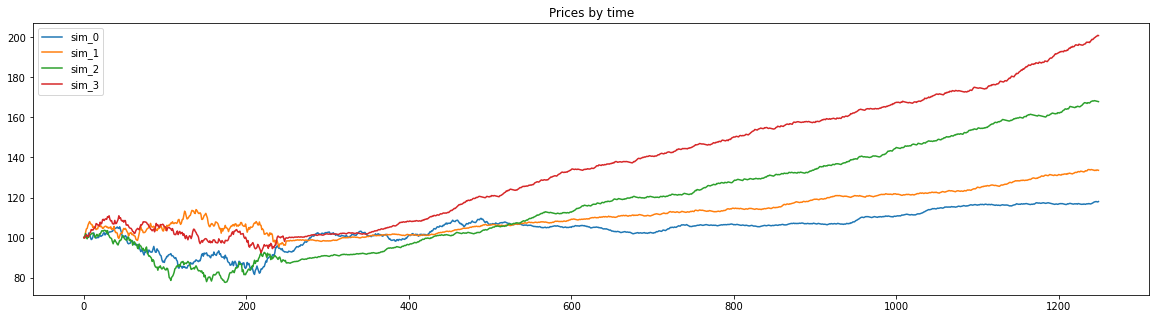

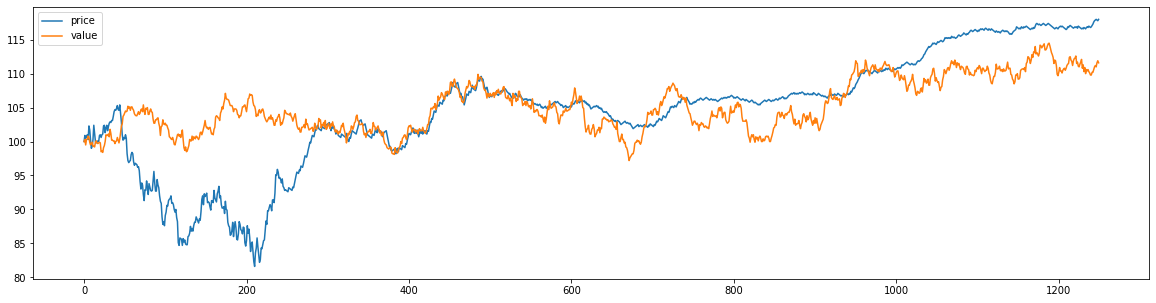

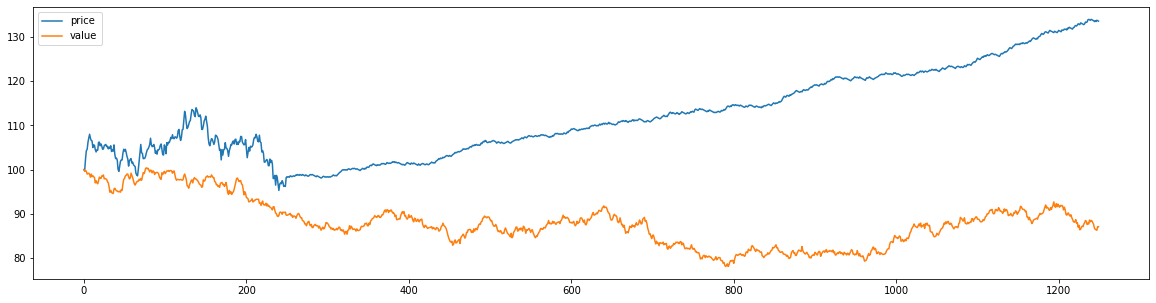

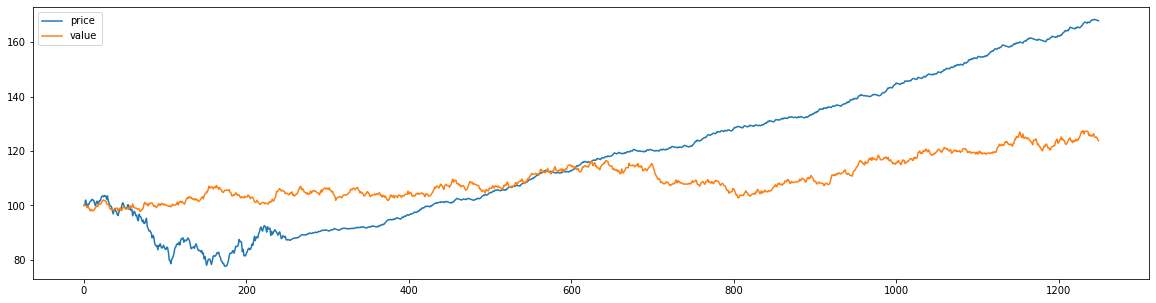

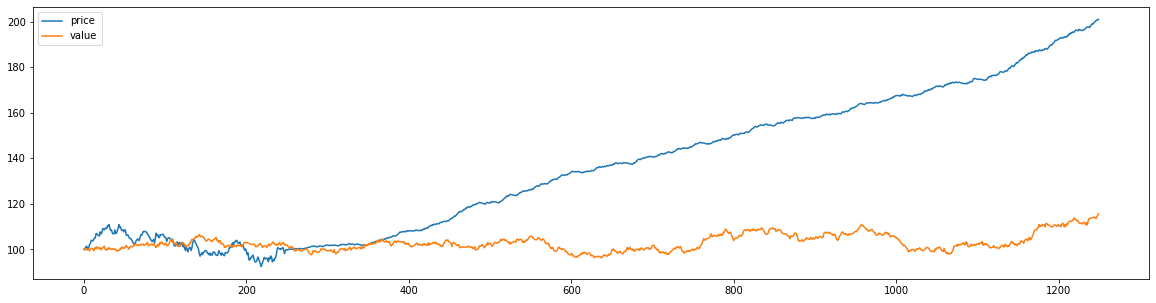

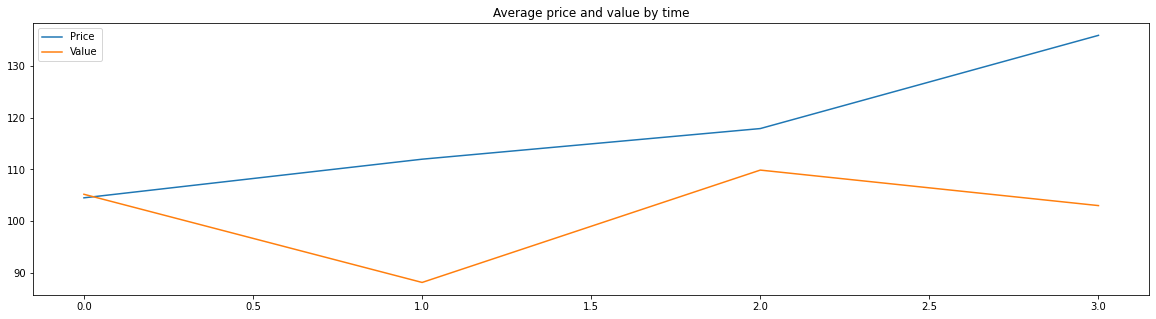

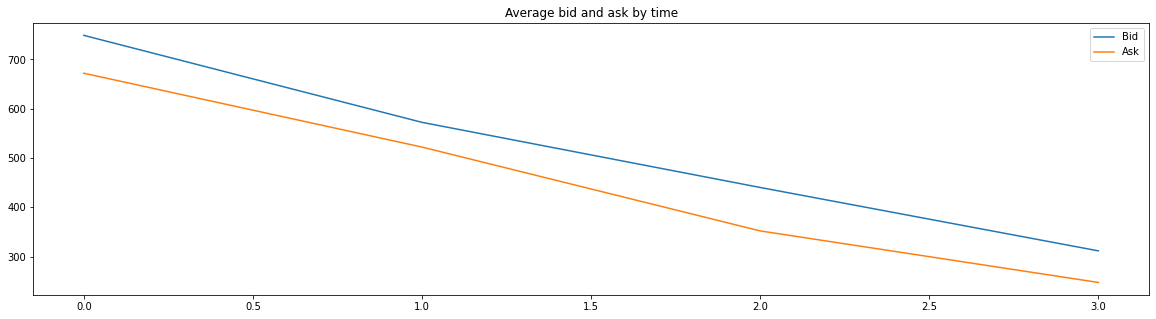

Average step per bid quantity per agent: 0.9650683847457432
Average step per ask quantity per agent: 1.1152947054729743


In [105]:
plot_market(train_markets)

### Agent returns

#### Distribution of total returns 

Rate of positive returns: 1.0
Rate of negtive returns: 0.0


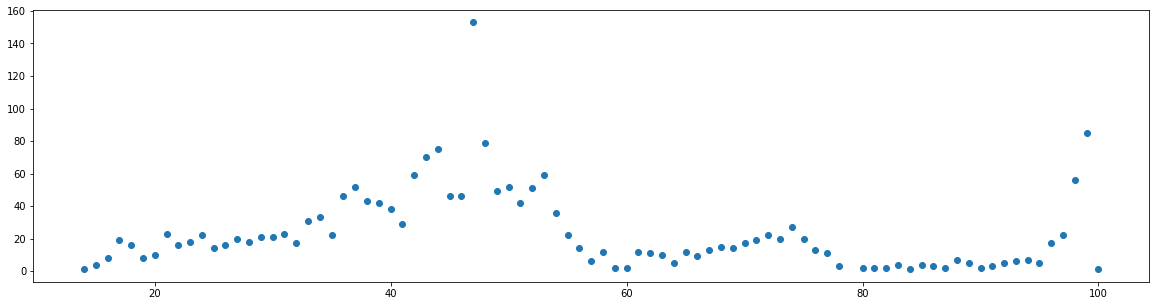

In [106]:
plot_total_distribution_of_return(train_rl_states)

#### Distribution of returns by agent

Positive progress: 0.998
Negative progress: 0.002


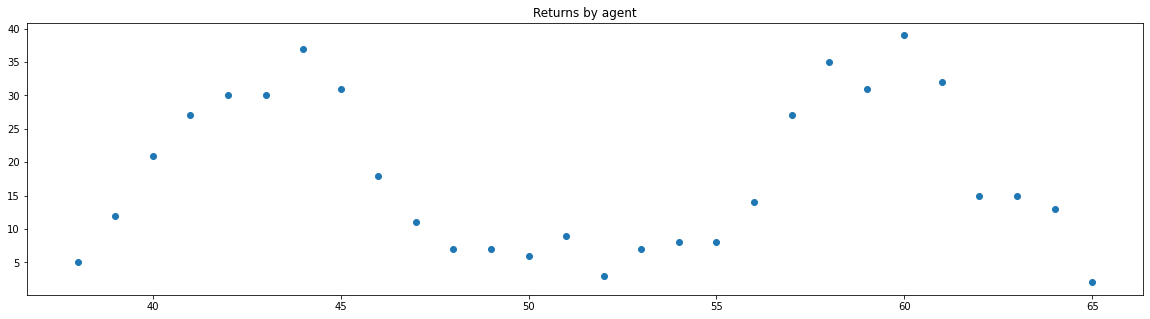

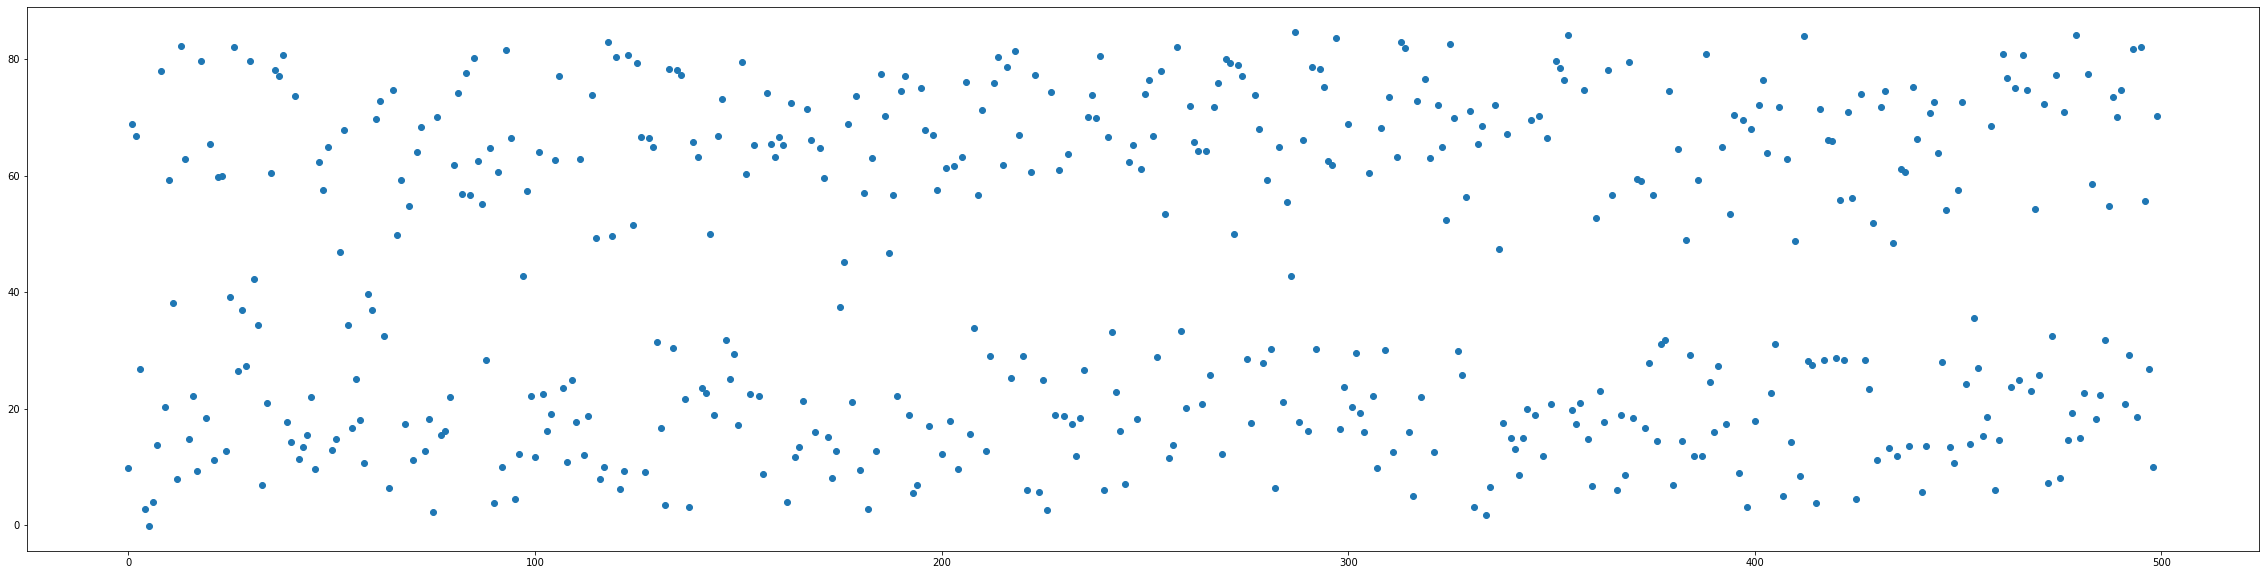

In [107]:
agent_returns = plot_distribution_of_return_by_agent(train_rl_states)

### Total loss

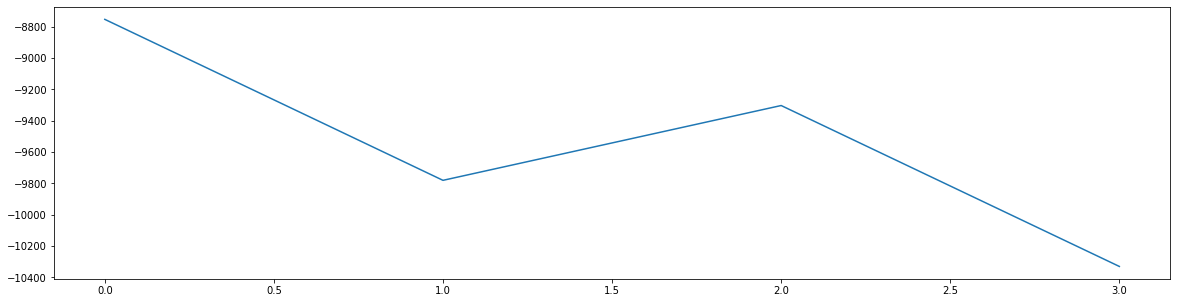

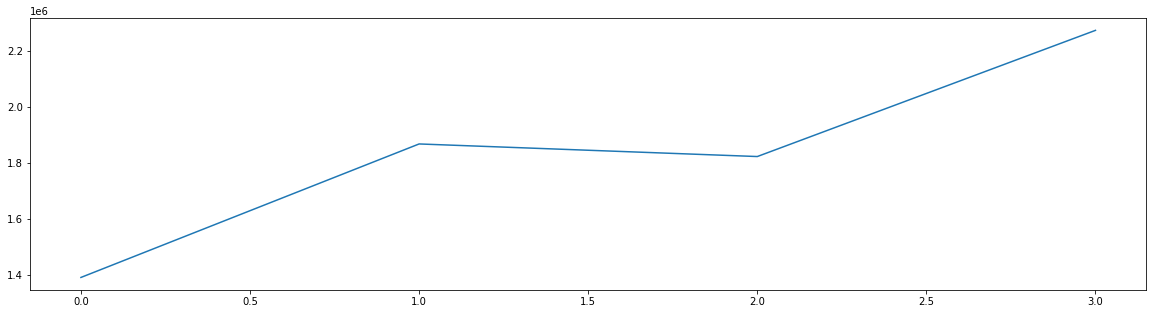

In [108]:
plot_average_loss_by_time(train_rl_states, train_markets, agent_ids)

### Sample agent

#### Trend

In [109]:
tr_agent_id = sample_agent_id(tr_group_name, tr_agent_number)

In [110]:
plot_wealth_by_time(train_rl_states, tr_agent_id)

KeyError: 'ppo_tr_500_165'

In [ ]:
plot_holdings(train_rl_states, tr_agent_id)

In [ ]:
plot_loss(train_rl_states, tr_agent_id)

In [ ]:
plot_reward_by_time(train_rl_states, tr_agent_id)

In [ ]:
plot_action_with_reward(train_rl_states, train_markets, tr_agent_id)

#### Value

In [ ]:
va_agent_id = sample_agent_id(va_group_name, va_agent_number)

In [ ]:
plot_wealth_by_time(train_rl_states, va_agent_id)

In [ ]:
plot_holdings(train_rl_states, va_agent_id)

In [ ]:
plot_loss(train_rl_states, va_agent_id)

In [ ]:
plot_reward_by_time(train_rl_states, va_agent_id)

In [ ]:
plot_action_with_reward(train_rl_states, train_markets, va_agent_id)

#### Scaling

In [ ]:
sc_agent_id = sample_agent_id(sc_group_name, sc_agent_number)

In [ ]:
plot_wealth_by_time(train_rl_states, sc_agent_id)

In [ ]:
plot_holdings(train_rl_states, sc_agent_id)

In [ ]:
plot_loss(train_rl_states, sc_agent_id)

In [ ]:
plot_reward_by_time(train_rl_states, sc_agent_id)

In [ ]:
plot_action_with_reward(train_rl_states, train_markets, sc_agent_id)

In [ ]:
for rl_state in train_rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        l = [state['observations'][i] for state in rl_state[sc_agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


## Validate

In [111]:
validate_dir_path = record_path / 'validate'
validate_markets, validate_agents, validate_rl_states, validate_lengths, validate_timesteps = get_plot_data(validate_dir_path)

Simulation times: 4
Average training length: 450.0


### Price & Value

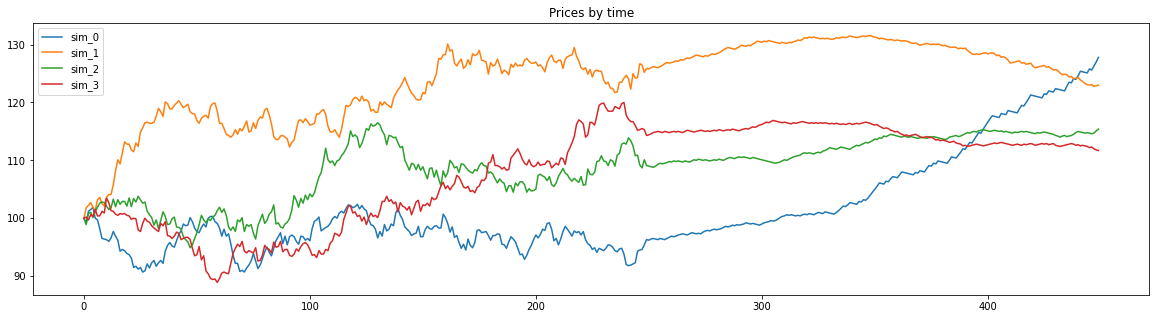

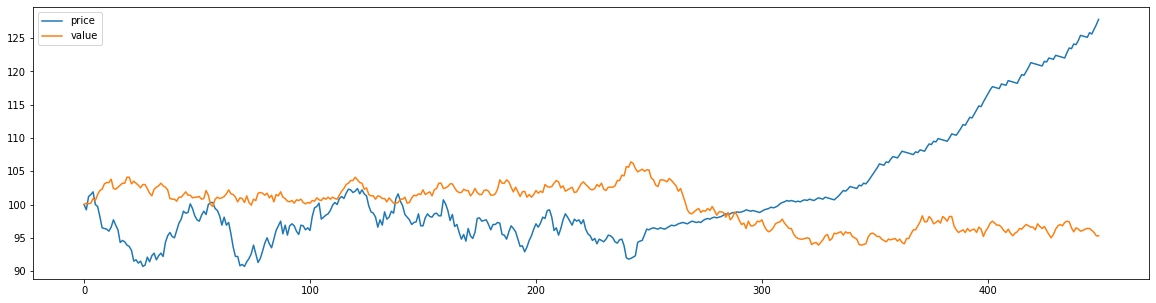

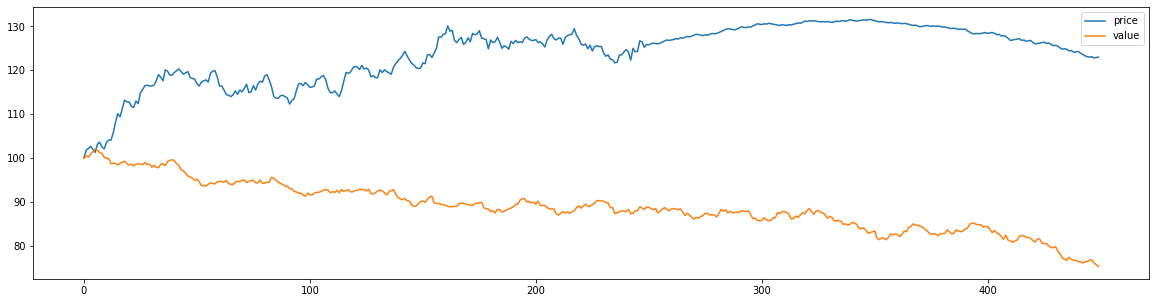

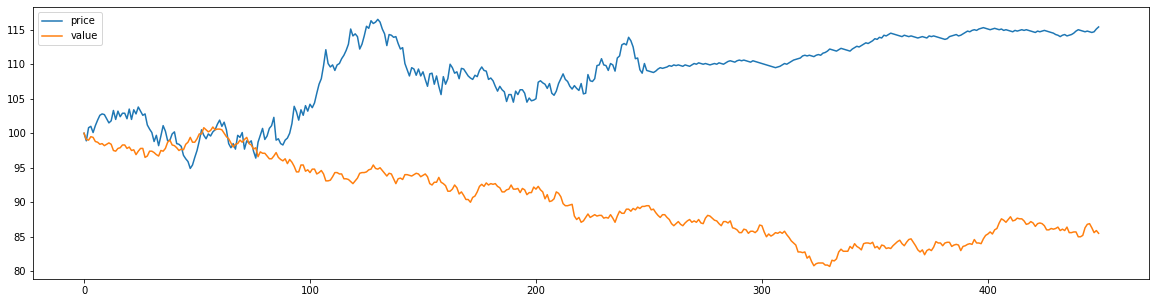

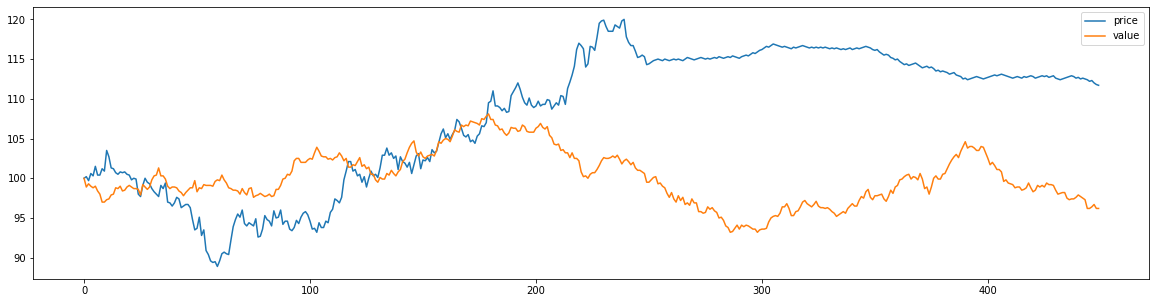

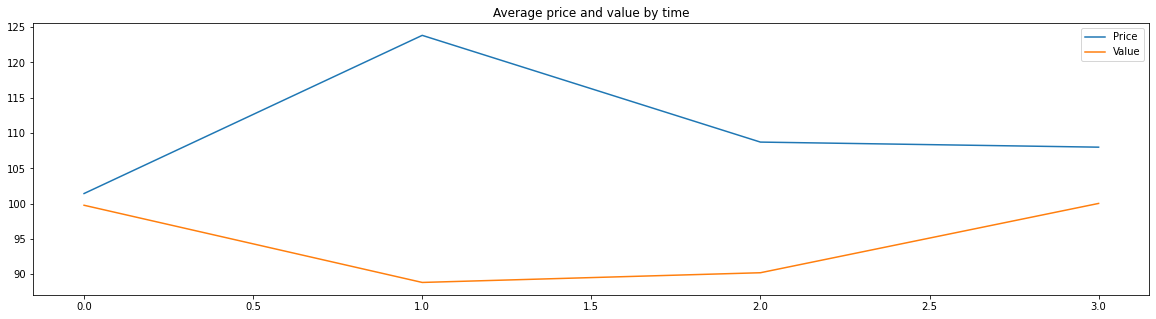

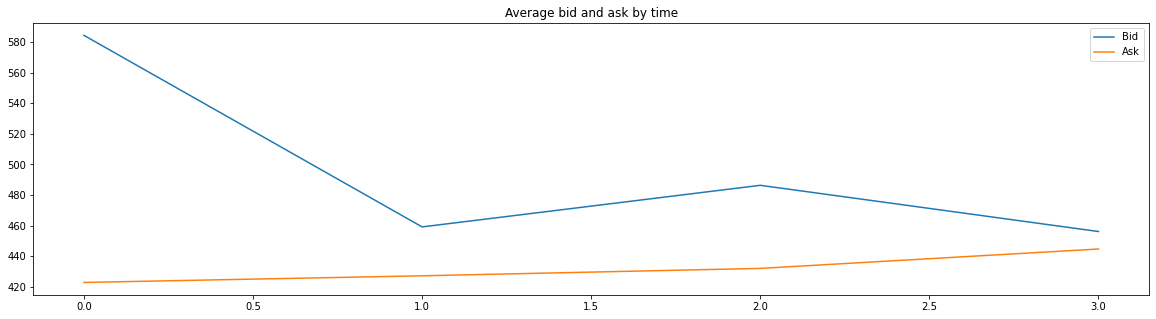

Average step per bid quantity per agent: 1.0070949841634314
Average step per ask quantity per agent: 1.158359299887639


In [112]:
plot_market(validate_markets)

### Agent returns

#### Distribution of total returns 

In [ ]:
plot_total_distribution_of_return(validate_rl_states)

#### Distribution of returns by agent

In [ ]:
plot_distribution_of_return_by_agent(validate_rl_states)

### Sample agent

#### Trend

In [ ]:
tr_agent_id = sample_agent_id(tr_group_name, tr_agent_number)

In [ ]:
plot_wealth_by_time(validate_rl_states, tr_agent_id)

In [ ]:
plot_holdings(validate_rl_states, tr_agent_id)

In [ ]:
plot_action(validate_rl_states, validate_markets, tr_agent_id)

#### Value

In [ ]:
va_agent_id = sample_agent_id(va_group_name, va_agent_number)

In [ ]:
plot_wealth_by_time(validate_rl_states, va_agent_id)

In [ ]:
plot_holdings(validate_rl_states, va_agent_id)

In [ ]:
plot_action(validate_rl_states, validate_markets, va_agent_id)

#### Scaling

In [ ]:
sc_agent_id = sample_agent_id(sc_group_name, sc_agent_number)

In [ ]:
plot_wealth_by_time(validate_rl_states, sc_agent_id)

In [ ]:
plot_holdings(validate_rl_states, sc_agent_id)

In [ ]:
plot_action_with_reward(validate_rl_states, validate_markets, sc_agent_id)

In [ ]:
for rl_state in validate_rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        l = [state['observations'][i] for state in rl_state[sc_agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


## Predict

In [113]:
predict_dir_path = record_path / 'predict'
predict_markets, predict_agents, predict_rl_states, predict_lengths, predict_timesteps = get_plot_data(predict_dir_path)

FileNotFoundError: [Errno 2] No such file or directory: 'simulation_result/multi/scaling_500_no_rule_randomwealthweight_wealthobs_noevent_high_ticks/predict/sim_0/TSMC.json'

### Price & Value

In [ ]:
plot_market(predict_markets)

### Agent returns

#### Distribution of total returns 

In [ ]:
plot_total_distribution_of_return(predict_rl_states)

#### Distribution of returns by agent

In [ ]:
plot_distribution_of_return_by_agent(predict_rl_states)

### Sample agent

#### Trend

In [ ]:
tr_agent_id = sample_agent_id(tr_group_name, tr_agent_number)

In [ ]:
plot_wealth_by_time(predict_rl_states, tr_agent_id)

In [ ]:
plot_holdings(predict_rl_states, tr_agent_id)

In [ ]:
plot_action(predict_rl_states, predict_markets, tr_agent_id)

#### Value

In [ ]:
va_agent_id = sample_agent_id(va_group_name, va_agent_number)

In [ ]:
plot_wealth_by_time(predict_rl_states, va_agent_id)

In [ ]:
plot_holdings(predict_rl_states, va_agent_id)

In [ ]:
plot_action(predict_rl_states, predict_markets, va_agent_id)

#### Scaling

In [ ]:
sc_agent_id = sample_agent_id(sc_group_name, sc_agent_number)

In [ ]:
plot_wealth_by_time(predict_rl_states, sc_agent_id)

In [ ]:
plot_holdings(predict_rl_states, sc_agent_id)

In [ ]:
plot_action(predict_rl_states, predict_markets, sc_agent_id)

In [ ]:
for rl_state in predict_rl_states:
    for i, item in enumerate(['opt_utility', 'pes_utility', 'fud_utility']):
        l = [state['observations'][i] for state in rl_state[sc_agent_id]['states']]
        plt.plot(l, label = item)
    plt.legend()
    plt.show()


## Agent

In [ ]:
agent = pd.read_json(agent_path)
group_names = agent.columns
num_of_timesteps = len(agent[group_names[0]]['cash'])

In [ ]:
# Holdings
for i, rl_state in enumerate(rl_states):
    agent_state = rl_state[agent_id]['states']
    cash = [state['cash'] for state in agent_state]
    holding = [state['TSMC'] for state in agent_state]
    wealth = [state['wealth'] for state in agent_state]
    plt.plot(wealth, label = f"sim_{i}")
    plt.legend()

In [ ]:
# Holdings
agent_state = rl_states[-1][agent_id]['states']
cash = [state['cash'] for state in agent_state]
holding = [state['TSMC'] for state in agent_state]
wealth = [state['wealth'] for state in agent_state]
plt.plot(cash, label = "Cash")
plt.plot(wealth, label = "Wealth")
plt.legend()
plt.show()
plt.plot(holding, label = "TSMC")
plt.legend()

### Holdings

#### Initial state

In [ ]:
num_agent = 0
total_cash, total_TSMC = 0, 0
zi_cash, zi_TSMC = 0, 0
for group_name in group_names:
    if 'dh' in group_name:
        continue
    elif 'zi' in group_name:
        zi_cash += sum(agent[group_name]['initial_cash_by_agent'])
        zi_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
    else:
        total_cash += sum(agent[group_name]['initial_cash_by_agent'])
        total_TSMC += sum([i['TSMC'] for i in agent[group_name]['initial_security_by_agent']])
        num_agent += len(agent[group_name]['initial_cash_by_agent'])

print(f"Number of agents: {num_agent}")
print(f"Total TSMC: {total_TSMC} Total cash: {total_cash}")
print(f"Average TSMC: {total_TSMC // num_agent} Average cash: {total_cash // num_agent}")
print(f"ZI TSMC: {zi_TSMC} ZI cash: {zi_cash}")
if 'dh_1' in group_names:
    print(f"Dahoo cash: {agent['dh_1']['initial_cash_by_agent'][0]}")

#### Wealth

In [ ]:
# for agent_type in agent.columns:
for group_name in agent.columns:
    plt.figure(figsize=(20, 10))
    plt.plot(agent[group_name]['wealth'])
    plt.title(group_name)
    plt.show()

In [ ]:
# normalize 
wealth = np.array([agent[group_name]['wealth'] for group_name in group_names])
std_wealth = (wealth - wealth[:, 0].reshape(-1, 1)) / wealth[:, 0].reshape(-1, 1)

plt.figure(figsize=(30, 20))
for i, group_name in enumerate(agent.columns):
    plt.plot(std_wealth[i], label = group_names[i])
plt.legend()

#### Cash

In [ ]:
plt.figure(figsize=(30, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['cash'], label = group_names[i])
plt.legend()
plt.show()

#### Security

In [ ]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['TSMC'], label = group_names[i])
plt.legend()
plt.show()

#### Portfolio

In [ ]:
plt.figure(figsize=(20, 10))

close_price = tsmc['close'].to_numpy()
for group_name in group_names:
    security_value = close_price * np.array(agent[group_name]['TSMC']) * 100
    security_propotion = security_value / (np.array(agent[group_name]['cash'])  + security_value)
    plt.plot(security_propotion)
    plt.title(group_name, size = 20)
    plt.show()

In [ ]:
# baseline_return = pow(1.01, 100) / 2
# for group_name in group_names:
#     plt.figure(figsize=(20, 10))
#     plt.axhline(y = baseline_return)
#     plt.scatter(agent[group_name]['initial_wealth_by_agent'], np.array(agent[group_name]['returns_by_agent']))
#     plt.xlabel('Initial wealth')
#     plt.ylabel('Return')
#     plt.title(f"{group_name}")
#     plt.show()

#### Average cost

In [ ]:
plt.figure(figsize=(20, 10))
for i, group_name in enumerate(agent.columns):
    plt.plot(agent[group_name]['average_cost'], label = group_names[i])
plt.legend()

### Orders

#### Number

#### Each group

In [ ]:
from collections import defaultdict

t = list(group_names)
for group_name in group_names:
    if 'zi' in group_name:
        continue
    bids_timestep, bids_price, bids_volume, asks_timestep, asks_price, asks_volume = [], [], [], [], [], []
    bids_price_volume = defaultdict(float)
    asks_price_volume = defaultdict(float)
    
    for i in range(len(agent[group_name]['timestep_bid'])):
        for price, volume in agent[group_name]['timestep_bid'][i].items():
            bids_timestep.append(i)
            bids_price.append(float(price))
            bids_volume.append(volume)
            bids_price_volume[float(price)] += volume
        for price, volume in agent[group_name]['timestep_ask'][i].items():
            asks_timestep.append(i)
            asks_price.append(float(price))
            asks_volume.append(volume)
            asks_price_volume[float(price)] += volume
    
    bids_size = [ 400*(volume - min(bids_volume)) / max(bids_volume) - min(bids_volume) for volume in bids_volume]
    asks_size = [ 400*(volume - min(asks_volume)) / max(asks_volume) - min(asks_volume) for volume in asks_volume]
    plt.plot(tsmc['close'])
    plt.scatter(bids_timestep, bids_price, s = bids_size, c = 'r', marker = 6)
    plt.scatter(asks_timestep, asks_price, s = asks_size, c = 'g', marker = 7)
    plt.title(group_name)
    plt.show()
    plt.bar(list(bids_price_volume.keys()), list(bids_price_volume.values()), color = 'r')
    plt.bar(list(asks_price_volume.keys()), np.array(list(asks_price_volume.values())) * -1, color = 'g')
    plt.show()


#### Propotion

In [ ]:
group_bids_volume = [agent.loc['group_bids_volume', group_name] for group_name in group_names]
group_bids_volume = np.array(group_bids_volume).T
group_bids_volume = group_bids_volume / group_bids_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(group_bids_volume[:, i], label = group_names[i])
# plt.ylim(0, 0.1)
plt.legend()

In [ ]:
group_asks_volume = [agent.loc['group_asks_volume', group_name] for group_name in group_names]
group_asks_volume = np.array(group_asks_volume).T
group_asks_volume = group_asks_volume / group_asks_volume.sum(axis = 1).reshape(-1, 1)
for i in range(len(group_names)):
#     if group_names[i] == 'zi_1000':
#         continue
    plt.plot(-1 * group_asks_volume[:, i], label = group_names[i])

# plt.ylim(-0.3, 0.2)
plt.legend()

## RL Agent

In [ ]:
import random

markets, agents, rl_states, lengths, timesteps = [], [], [], [], []
for _dir in validate_dirs:
    record_dir = result_dir / 'validate' / _dir
    security_path = record_dir / "TSMC.json"
    agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
    config_path = result_dir / 'config.json'
    market = json.loads(security_path.read_text())
    markets.append(market)
    agents.append(json.loads(agent_path.read_text()))
    rl_states.append(json.loads(rl_path.read_text()))
    lengths.append(len(market['price']))
    timesteps.append([i for i in range(len(market['price']))])

In [ ]:
print(f"Average length: {sum(lengths) / len(lengths)}")

In [ ]:
for timestep, action in enumerate(actions):
    if action[0] == 0:
        bid_x.append(timestep + 100)
        bid_y.append(action[1]*0.1)
        bid_colors.append('r')
        bid_sizes.append(base_size * action[2])
    elif action[0] == 1:
        ask_x.append(timestep + 100)
        ask_y.append(action[1]*0.1)
        ask_colors.append('g')
        ask_sizes.append(base_size * action[2])

In [ ]:
for group in config['Agent']['RLAgent']:
    group_name = group['name']
    group_number = group['number']
    sample_id = f"{group_name}_{group_number}_{random.randint(0, group_number-1)}"
    state = rl_states[sample_id]
    print(sample_id)
    holdings_df = pd.DataFrame(rl_states[sample_id]['states'])
    plt.plot(holdings_df.wealth / holdings_df.wealth[0], label = "wealth")
    plt.plot(holdings_df.TSMC / holdings_df.TSMC[0], label = "TSMC")
    plt.plot(holdings_df.cash / holdings_df.cash[0], label = "cash")
    plt.legend()
    plt.show()
    
    actions = rl_states[sample_id]['actions']
    actions_df = pd.DataFrame(rl_states[sample_id]['actions'], columns = ['action', 'tick', 'volume'])
    print(f"Bid rate: {actions_df.action.eq(0).mean()}, Ask rate: {actions_df.action.eq(1).mean()}, Hold rate: {actions_df.action.eq(2).mean()}")
    bid_x, bid_y = [], []
    ask_x, ask_y = [], []
    bid_sizes, ask_sizes = [], []
    bid_colors, ask_colors = [], []
    base_size = 200
    for timestep, action in enumerate(actions):
        if action[0] == 0:
            bid_x.append(timestep + 100)
            bid_y.append(action[1]*0.1)
            bid_colors.append('r')
            bid_sizes.append(base_size * action[2])
        elif action[0] == 1:
            ask_x.append(timestep + 100)
            ask_y.append(action[1]*0.1)
            ask_colors.append('g')
            ask_sizes.append(base_size * action[2])
            
    x = np.arange(2500)
    plt.figure(figsize=(80, 20))
    plt.plot(x, market['price'][100:])
    plt.scatter(bid_x, a, s = bid_sizes, c = bid_colors, marker = 6)
    plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
    plt.show()

        
    break

### Relation of reward and performance

In [ ]:
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)
state = rl_states[agent_id]
rewards = state['rewards']


In [ ]:
plt.plot(timesteps, rewards, label = ['action', 'wealth', 'is_valid'])
plt.legend()

In [ ]:
sim_num = len(train_dirs)
length = len(market['price'][100:])
timesteps = [i for i in range(length)]
agent_ids = list(rl_states.keys())
agent_id = random.sample(agent_ids, 1)[0]

total_rewards = []
for i in range(sim_num):
    record_dir = result_dir / 'train' / f'sim_{i}'
#     security_path = record_dir / "TSMC.json"
#     agent_path = record_dir / "agent.json"
    rl_path = record_dir / 'rl_agent.json'
#     market = json.loads(security_path.read_text())
#     agents = json.loads(agent_path.read_text())
    rl_states = json.loads(rl_path.read_text())
    total_rewards.append(rl_states[agent_id]['rewards'])


In [ ]:
action_rewards = []
wealth_rewards = []
valid_rewards = []

tr = np.array(total_rewards)
total_reward_by_type = tr.reshape([-1, 3])

In [ ]:
plt.plot(total_reward_by_type, label = ['action', 'wealth', 'is_valid'])
plt.legend()

### Orders

In [ ]:
agents.keys()

In [ ]:
rl_states['ppo_tr_100_0']

### Distribution of actions along times from random agent

In [ ]:
prices = market['price'][100:]
bids = market['bid_five_price']
asks = market['ask_five_price']
bid_or_asks = []
agent_id = random.sample(agent_ids, 1)[0]
state = rl_states[agent_id]
counters = []
for agent_id, state in rl_states.items():
    bid_or_asks = []
    for i, action in enumerate(state['actions']):
        bid_or_ask = action[0]
        ticks = action[1]
        volume = action[2] + 1
        current_price = prices[i]
        tick_size = 0.1

        if bid_or_ask == 2:
            pass
        elif bid_or_ask == 0:
            # bid
            best_bids = list(bids[i])
            best_bid = current_price if len(best_bids) == 0 else float(best_bids[0])
            price = round(best_bid + (4-ticks) * tick_size, 2)

        elif bid_or_ask == 1:
            # ask
            best_asks = list(asks[i])
            best_ask = current_price if len(best_asks) == 0 else float(best_asks[0])
            price = round(best_ask + (ticks-4) * tick_size, 2)
        bid_or_asks.append(bid_or_ask)


    counter = {0: 0, 1: 0, 2: 0}
    for a in bid_or_asks:
        counter[a] += 1
    counters.append(counter)


In [ ]:
hold_times = {i: 0 for i in range(length+1)}
bid_times = {i: 0 for i in range(length+1)}
ask_times = {i: 0 for i in range(length+1)}

for counter in counters:
    bid_times[counter[0]] += 1
    ask_times[counter[1]] += 1
    hold_times[counter[2]] += 1
    

In [ ]:
plt.plot(timesteps, list(hold_times.values()), 'r')
plt.plot(timesteps, list(bid_times.values()), 'b')
plt.plot(timesteps, list(ask_times.values()), 'g')

In [ ]:
# append data for maintaining the same length
rl_states['states'][-1]['action'] = rl_states['states'][-2]['action']
rl_states['states'][-1]['reward'] = rl_states['states'][-2]['reward']

In [ ]:
rl_dict = {}
for k, v in rl_states['states'][0].items():
    if type(v) != dict:
        rl_dict[k] = []
    else:
        for key in v.keys():
            rl_dict[key] = []

In [ ]:
for state in rl_states['states']:
    for k, v in state.items():
        if type(v) != dict:
            rl_dict[k].append(v)
        else:
            for key, value in v.items():
                rl_dict[key].append(value)

In [ ]:
rl_df = pd.DataFrame(rl_dict)
rl_df

Reward

In [ ]:
plt.plot(rl_df.wealth / rl_df.wealth[0])
plt.plot(rl_df.wealth_reward)

Action

In [ ]:
'''
1. Discrete 3 - BUY[0], SELL[1], HOLD[2]
2. Discrete 9 - TICK_-4[0], TICK_-3[1], TICK_-2[2], TICK_-1[3], TICK_0[4], TICK_1[5], TICK_2[6], TICK_3[7], TICK_4[8]
3. Discrete 5 - VOLUME_1[0], VOLUME_2[1], VOLUME_3[2], VOLUME_4[3], VOLUME_5[4],
'''
valid_action_rate = rl_df.is_valid.mean()
bid_rate = rl_df.action.apply(lambda x: int(x[0]) == 0).mean()
ask_rate = rl_df.action.apply(lambda x: int(x[1]) == 0).mean()
hold_rate = rl_df.action.apply(lambda x: int(x[2]) == 0).mean()
print(f"Bid rate: {bid_rate}\nAsk rate: {ask_rate}\nHold rate: {hold_rate}\nValid action rate: {valid_action_rate}")

In [ ]:
rl_orders = rl_states['orders']

In [ ]:
bid_x, bid_y = [], []
ask_x, ask_y = [], []
bid_sizes, ask_sizes = [], []
bid_colors, ask_colors = [], []
base_size = 200
for order in rl_orders:
    if order['bid_or_ask'] == 'BID':
        if order['time'] > 5000 and order['time'] < 5100:
            bid_x.append(order['time'])
            bid_y.append(order['price'])
            bid_colors.append('r')
            bid_sizes.append(base_size * order['volume'])
    if order['bid_or_ask'] == 'ASK':
        if order['time'] > 5000 and order['time'] < 5100:
            ask_x.append(order['time'])
            ask_y.append(order['price'])
            ask_colors.append('g')  
            ask_sizes.append(base_size * order['volume'])

In [ ]:
x = np.arange(len(tsmc['close']))
plt.figure(figsize=(80, 20))
plt.plot(x[4999: 5101], tsmc['close'][4999:5101])
plt.scatter(bid_x, bid_y, s = bid_sizes, c = bid_colors, marker = 6)
plt.scatter(ask_x, ask_y, s = ask_sizes, c = ask_colors, marker = 7)
plt.show()